# Predict if a diabetic patient was readmitted to the hospital

Diabetic patients have a high risk of being readmitted to hospitals which have a huge impact on their lifestyle and also on healthcare expenditure. In this project the diabetic readmission dataset is used to predict readmission of high-risk patients. 

# Import modules

In [76]:
# import the necessary libraries and packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
#import imutils
#import cv2
import csv
import sklearn
import scipy
import missingno as msno

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from __future__ import print_function
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif , mutual_info_classif


# Load the data:

In [77]:
#Load data 
data = pd.read_csv('/content/sample_data/diabetic_data.csv')
# Dimension of data
data.shape

(101766, 50)

# Explore the data:

In [78]:
# Check the data types of columns
print(data.dtypes)

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [79]:
#Get a description of numerical features in the data
data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [80]:

# Check the number of unique values in each column
print(data.nunique())


encounter_id                101766
patient_nbr                  71518
race                             6
gender                           3
age                             10
weight                          10
admission_type_id                8
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
payer_code                      18
medical_specialty               73
num_lab_procedures             118
num_procedures                   7
num_medications                 75
number_outpatient               39
number_emergency                33
number_inpatient                21
diag_1                         717
diag_2                         749
diag_3                         790
number_diagnoses                16
max_glu_serum                    4
A1Cresult                        4
metformin                        4
repaglinide                      4
nateglinide                      4
chlorpropamide                   4
glimepiride         

Caucasians represent the majority of the patiens in terms of race. This could lead to a bias in the data results. More on this in the report.  

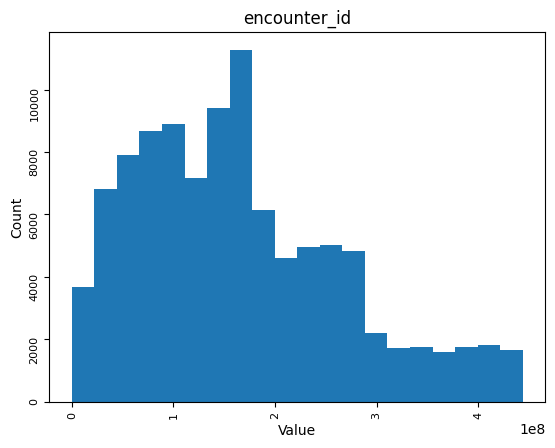

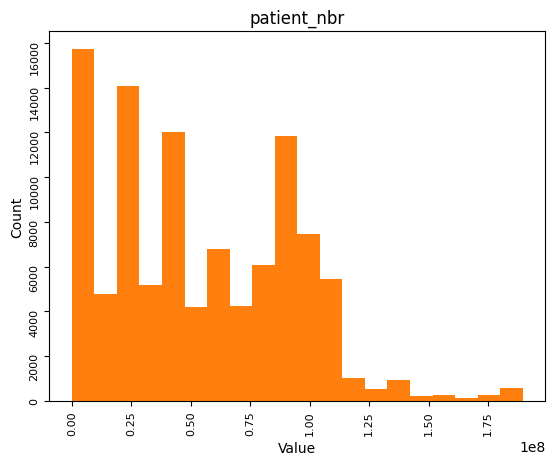

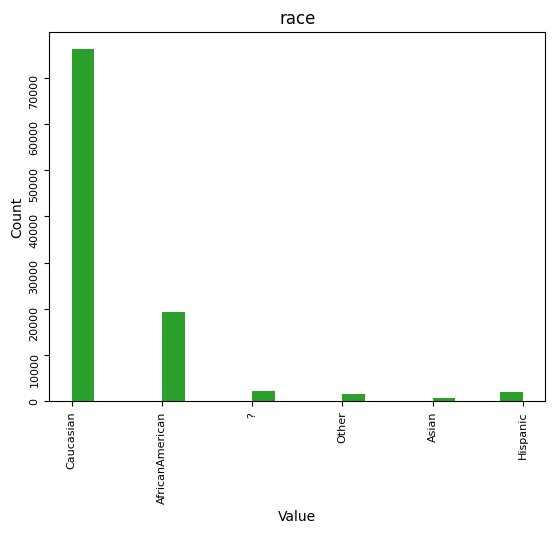

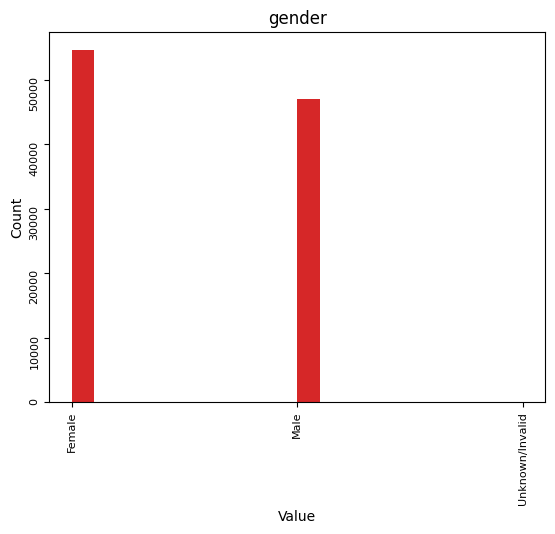

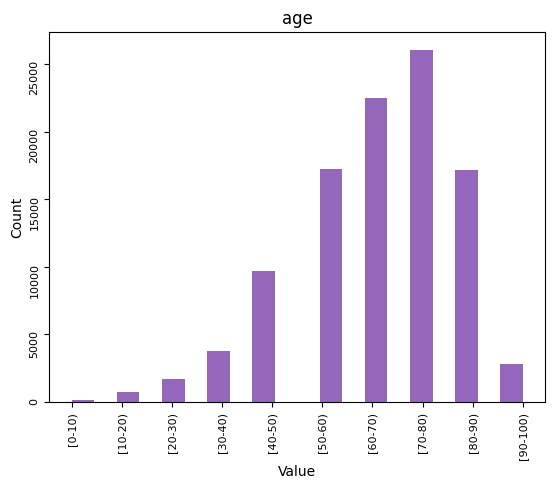

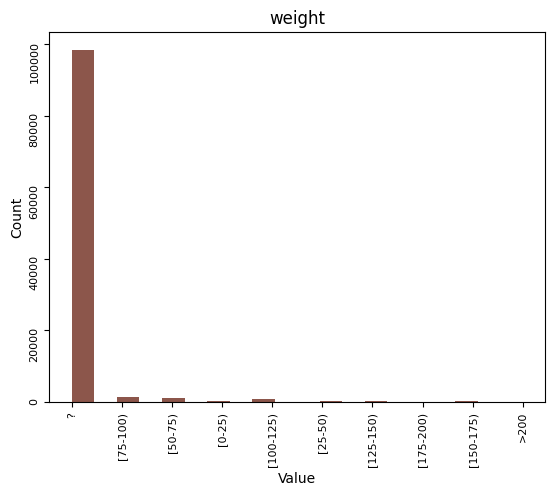

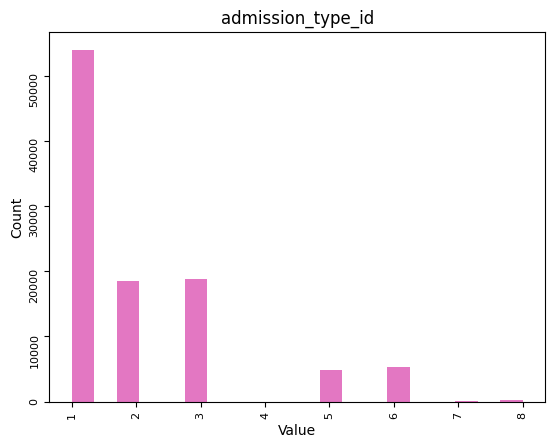

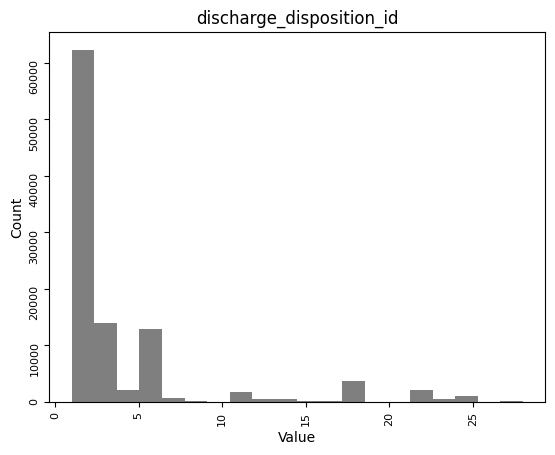

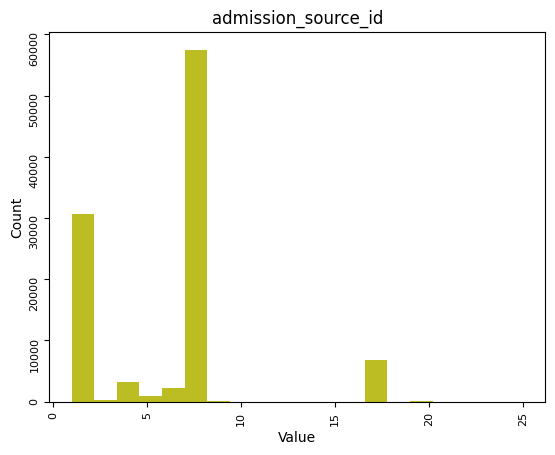

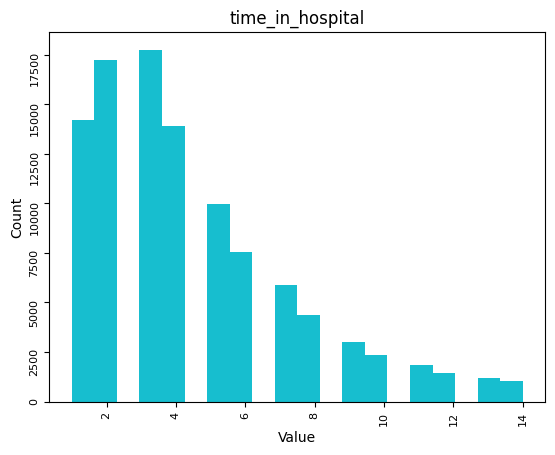

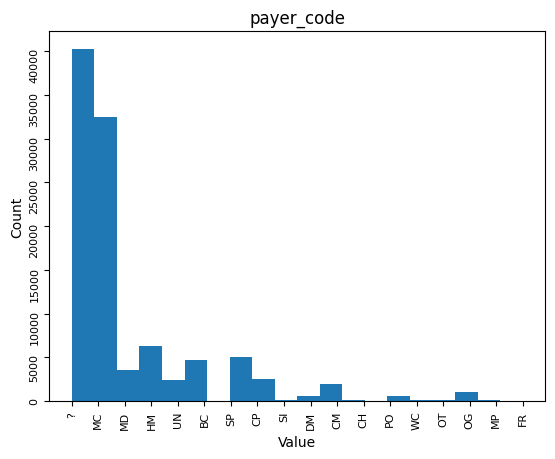

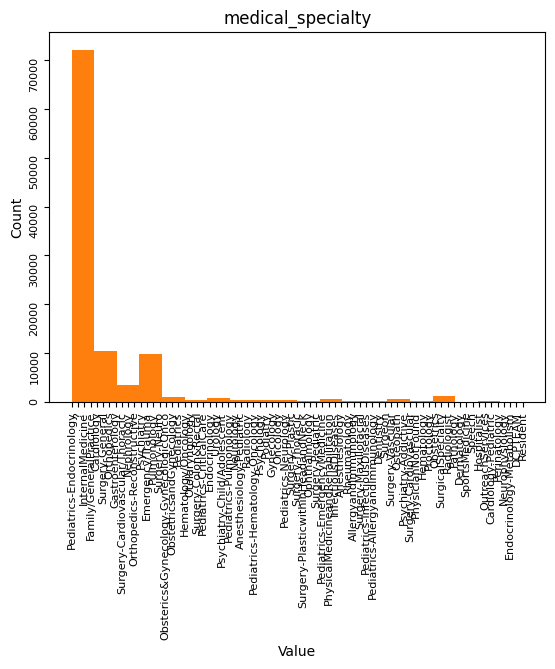

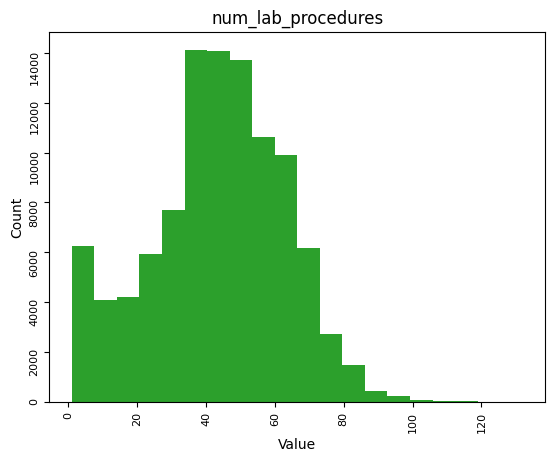

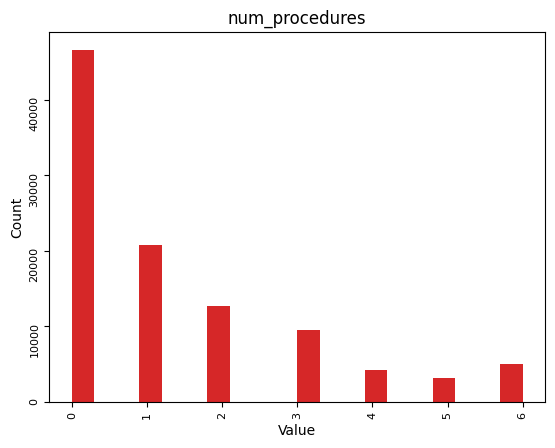

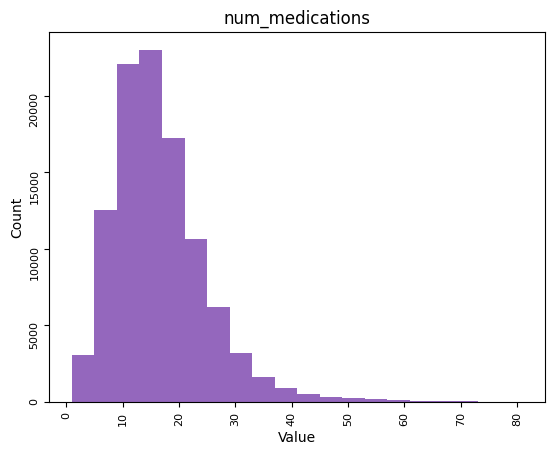

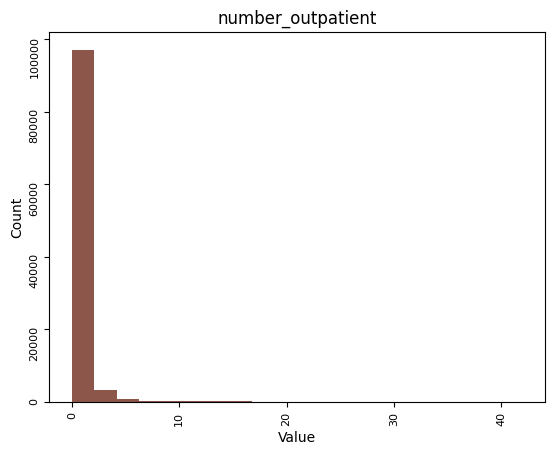

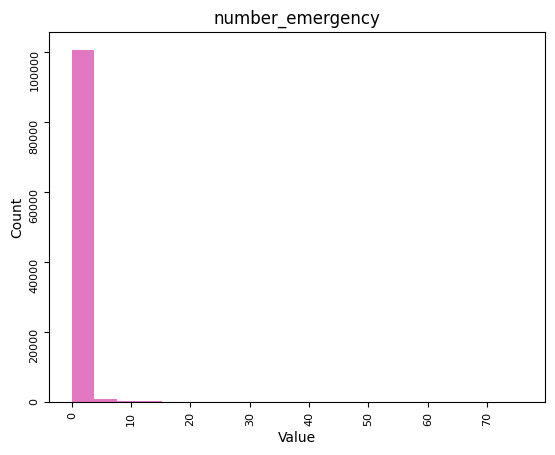

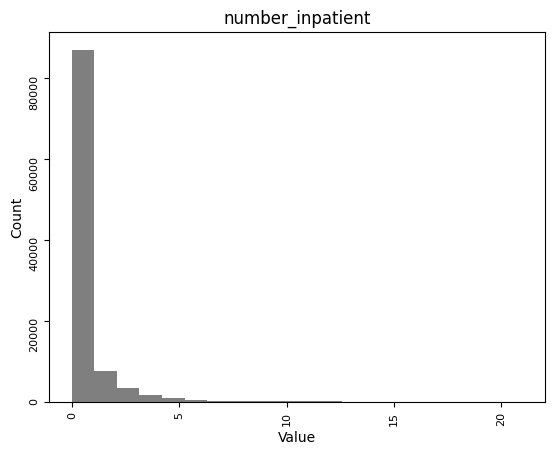

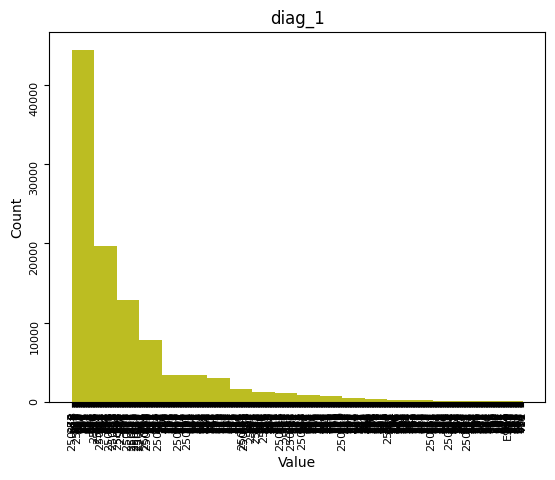

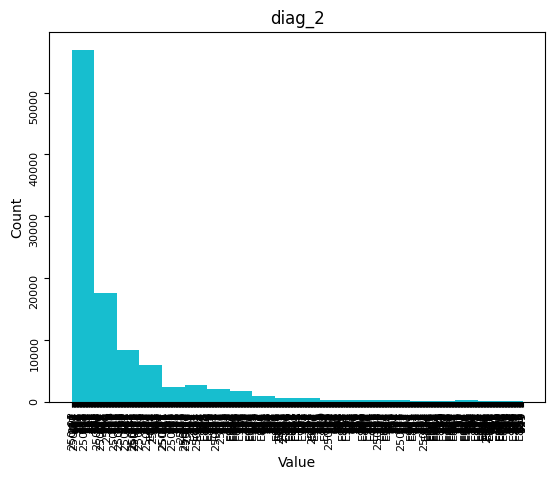

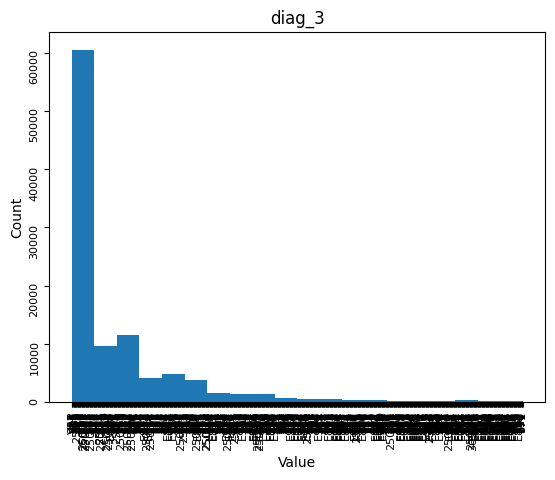

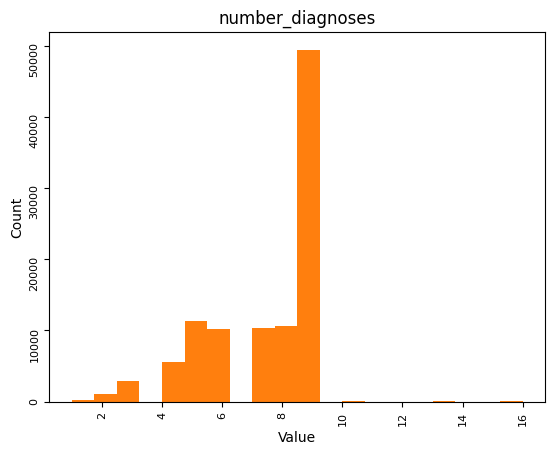

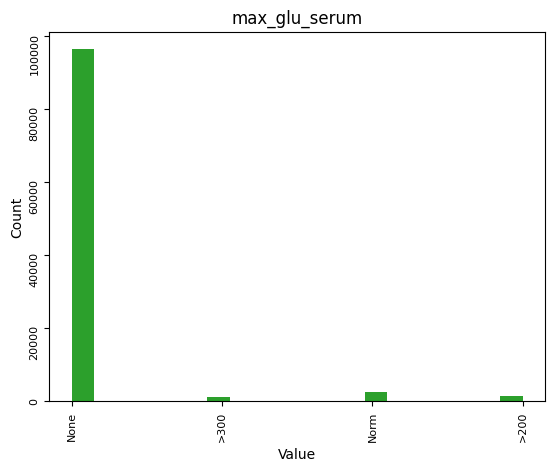

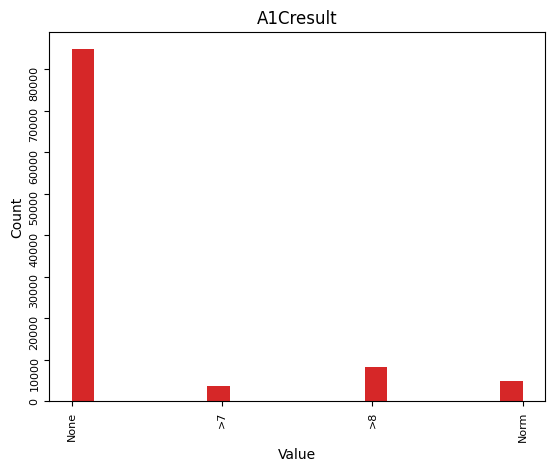

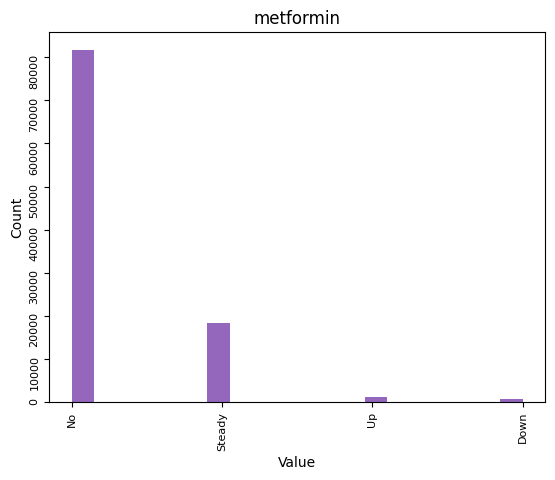

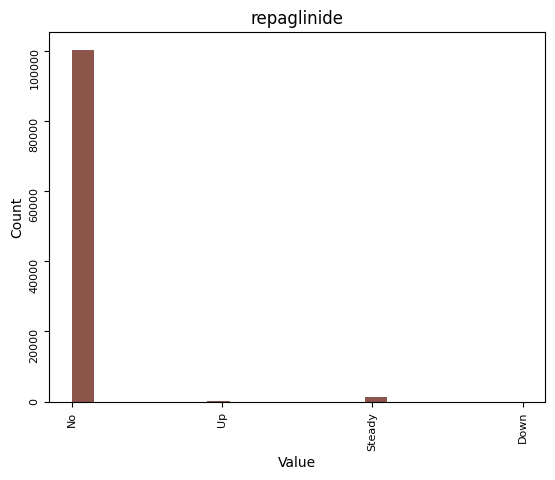

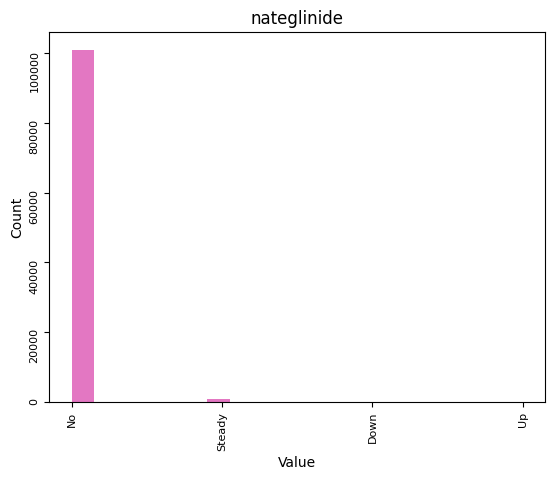

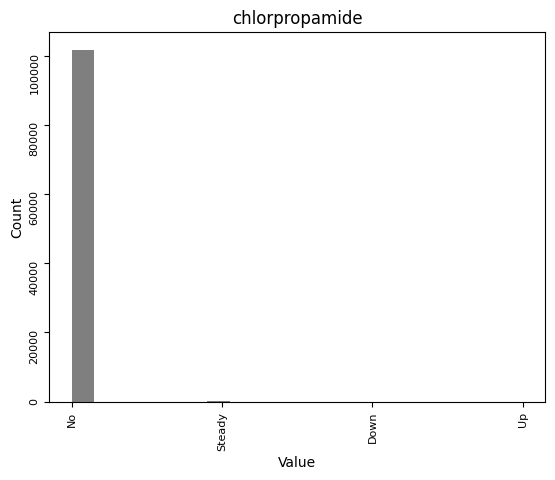

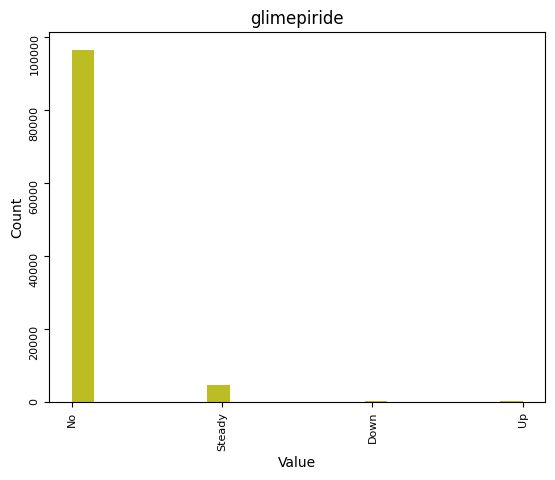

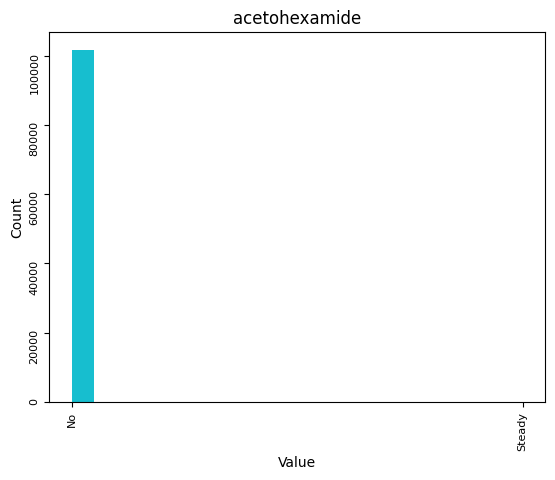

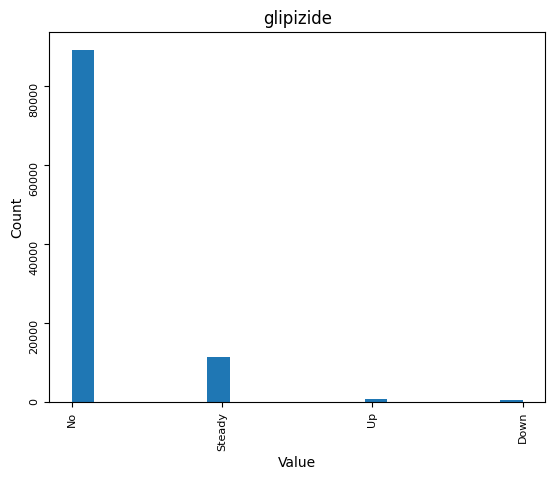

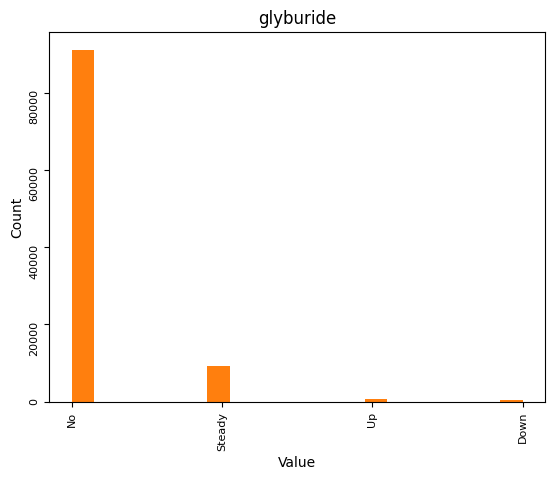

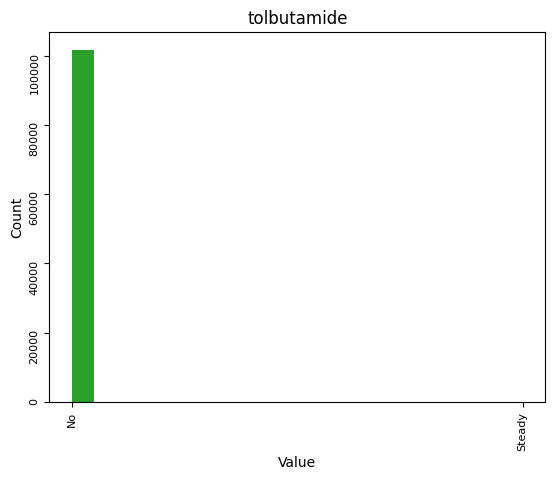

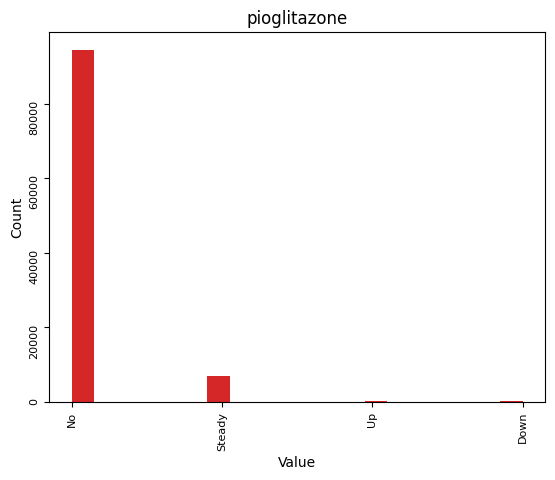

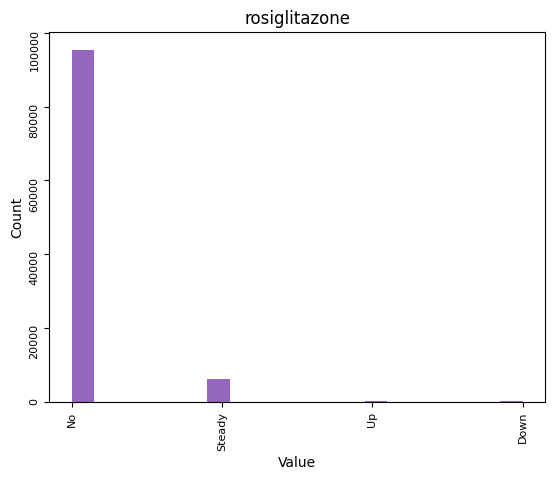

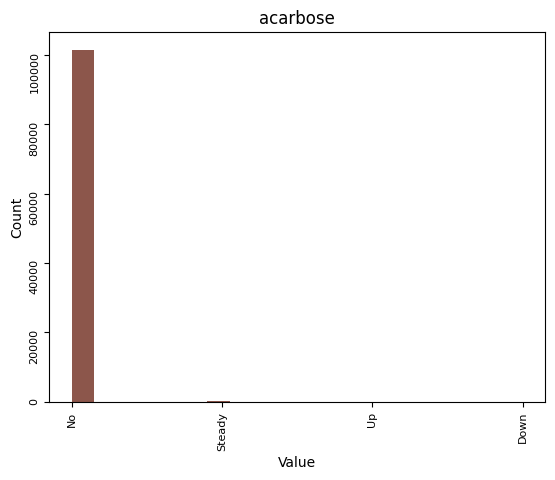

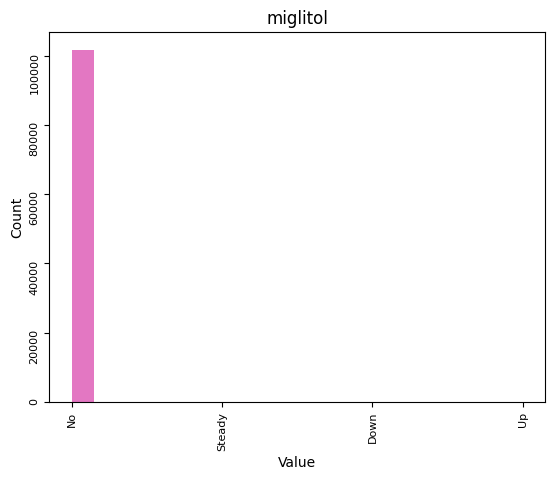

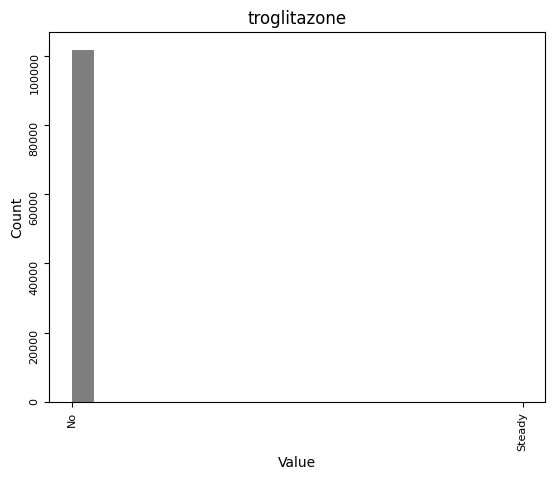

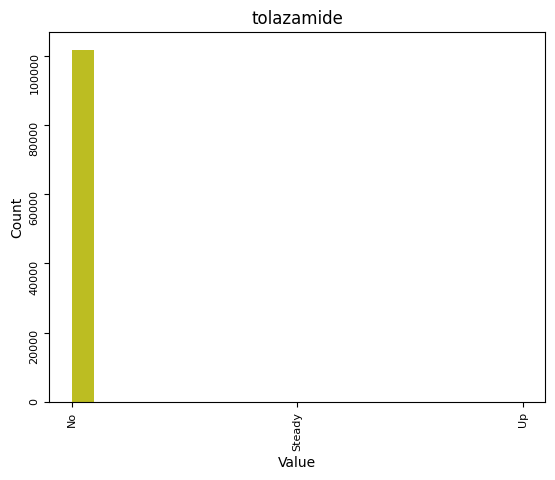

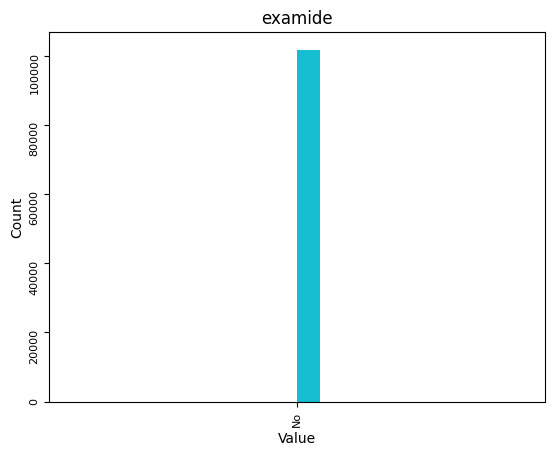

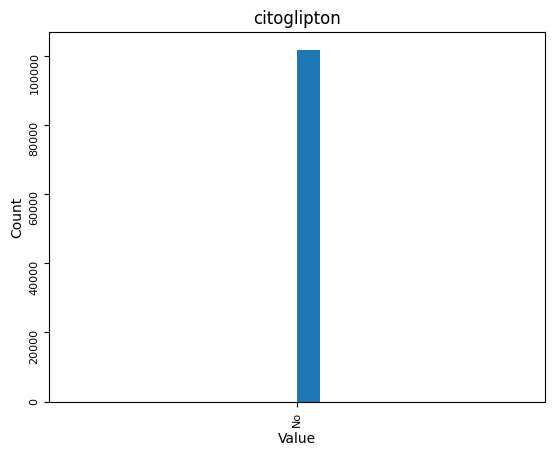

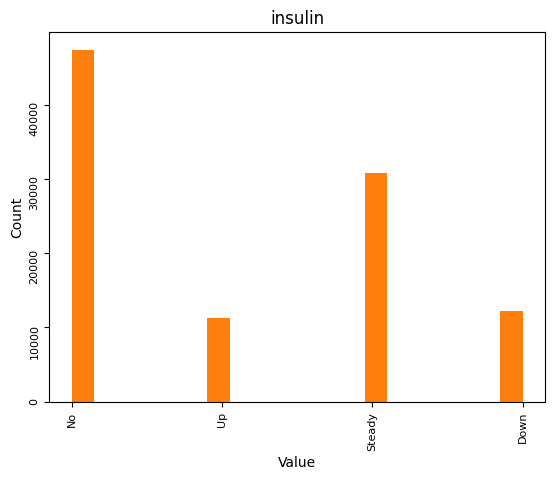

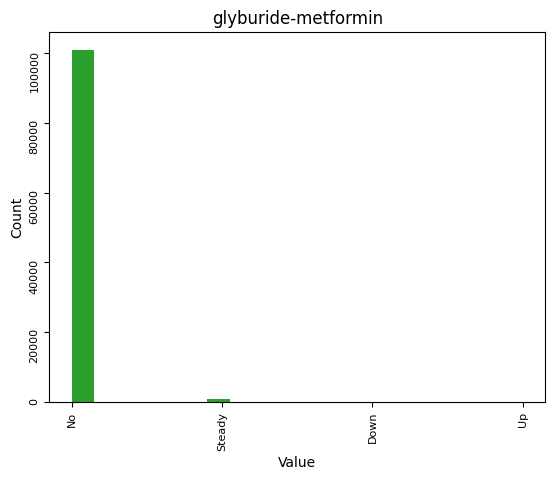

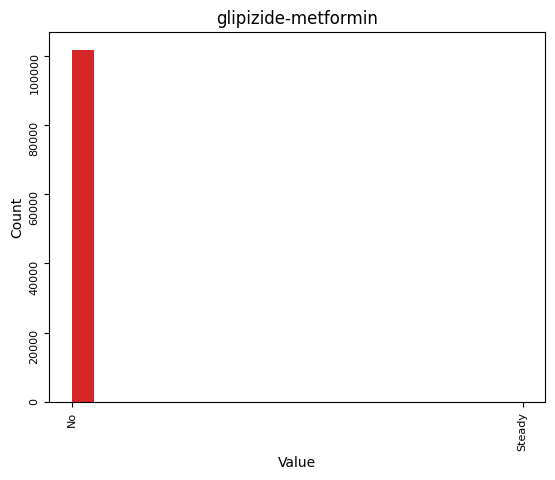

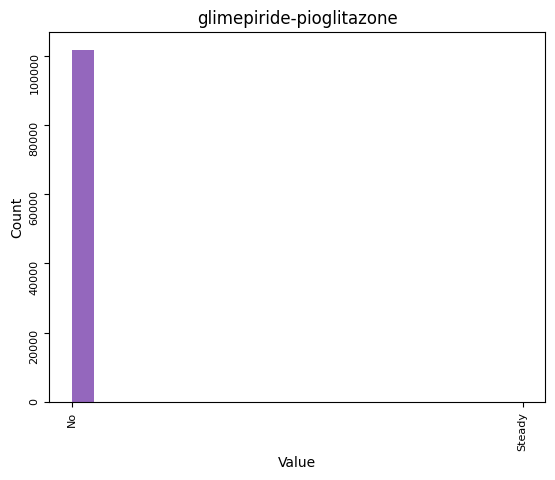

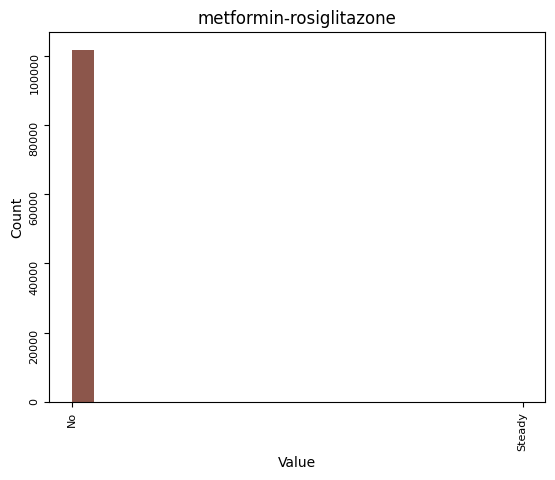

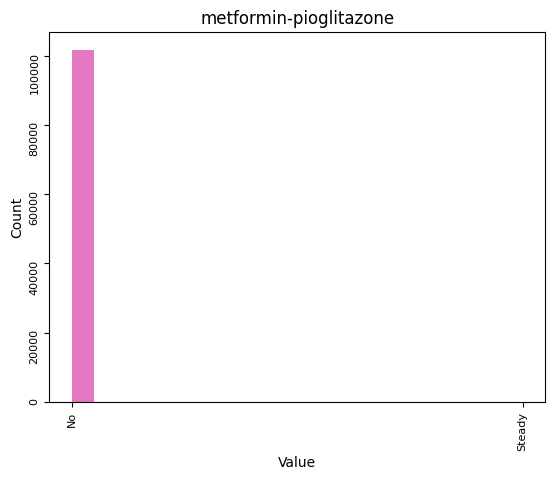

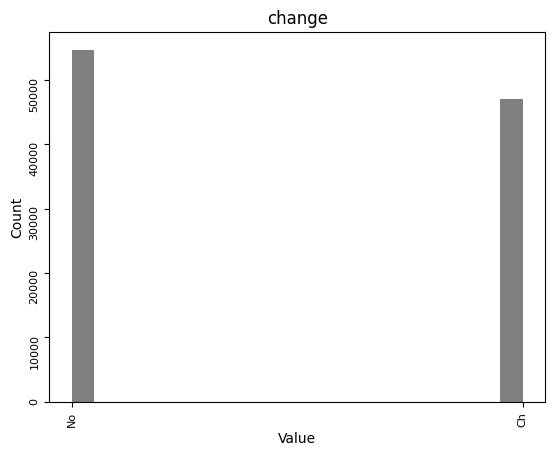

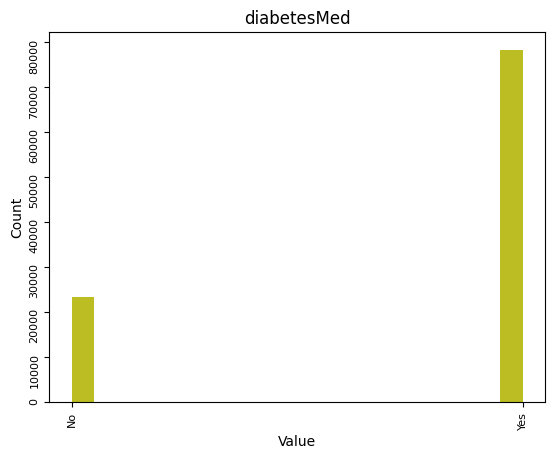

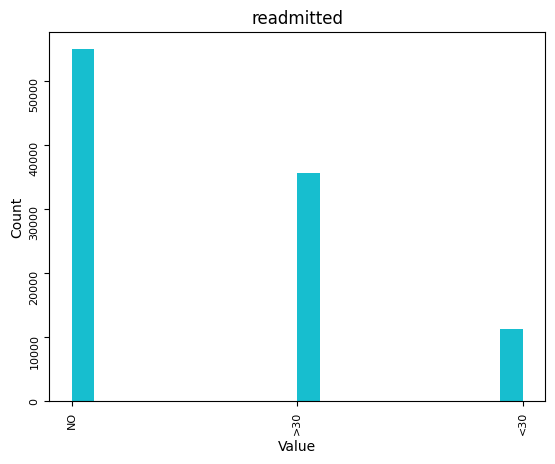

In [81]:

# Define color palette for the histograms
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a color-coded histogram for each column
for i, column in enumerate(data.columns):
    
    plt.figure(i)
    plt.hist(data[column], bins=20, color=colors[i % len(colors)])
    plt.title(column, fontsize=12)
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=8,labelrotation=90)
    #ax[i].tick_params(axis='x', labelrotation=90)
    plt.show()

In [82]:

# Count the number of patients taking diabetes medication
diabetes_med_count = data[data['diabetesMed'] == 'Yes'].shape[0]

# Calculate the percentage of patients taking diabetes medication
diabetes_med_percent = (diabetes_med_count / data.shape[0]) * 100

print("Percentage of patients taking diabetes medication: {:.2f}%".format(diabetes_med_percent))

Percentage of patients taking diabetes medication: 77.00%


In [83]:
# Group the dataset by number of diagnoses and count the number of patients in each group
diagnosis_counts = data.groupby('number_diagnoses')['patient_nbr'].count()

# Calculate the percentage of patients in each group
diagnosis_percentages = (diagnosis_counts / data.shape[0]) * 100

# Print the percentage of patients in each group
print("Percentage of patients with respect to the number of diagnoses:")
print(diagnosis_percentages)

Percentage of patients with respect to the number of diagnoses:
number_diagnoses
1      0.215200
2      1.005247
3      2.785803
4      5.440913
5     11.195291
6      9.984671
7     10.212645
8     10.431775
9     48.615451
10     0.016705
11     0.010809
12     0.008844
13     0.015722
14     0.006879
15     0.009826
16     0.044219
Name: patient_nbr, dtype: float64


# Pre-process the data:

encounter_id: 0.00%
patient_nbr: 0.00%
race: 2.23%
gender: 0.00%
age: 0.00%
weight: 96.86%
admission_type_id: 0.00%
discharge_disposition_id: 0.00%
admission_source_id: 0.00%
time_in_hospital: 0.00%
payer_code: 39.56%
medical_specialty: 49.08%
num_lab_procedures: 0.00%
num_procedures: 0.00%
num_medications: 0.00%
number_outpatient: 0.00%
number_emergency: 0.00%
number_inpatient: 0.00%
diag_1: 0.02%
diag_2: 0.35%
diag_3: 1.40%
number_diagnoses: 0.00%
max_glu_serum: 0.00%
A1Cresult: 0.00%
metformin: 0.00%
repaglinide: 0.00%
nateglinide: 0.00%
chlorpropamide: 0.00%
glimepiride: 0.00%
acetohexamide: 0.00%
glipizide: 0.00%
glyburide: 0.00%
tolbutamide: 0.00%
pioglitazone: 0.00%
rosiglitazone: 0.00%
acarbose: 0.00%
miglitol: 0.00%
troglitazone: 0.00%
tolazamide: 0.00%
examide: 0.00%
citoglipton: 0.00%
insulin: 0.00%
glyburide-metformin: 0.00%
glipizide-metformin: 0.00%
glimepiride-pioglitazone: 0.00%
metformin-rosiglitazone: 0.00%
metformin-pioglitazone: 0.00%
change: 0.00%
diabetesMed: 0.00

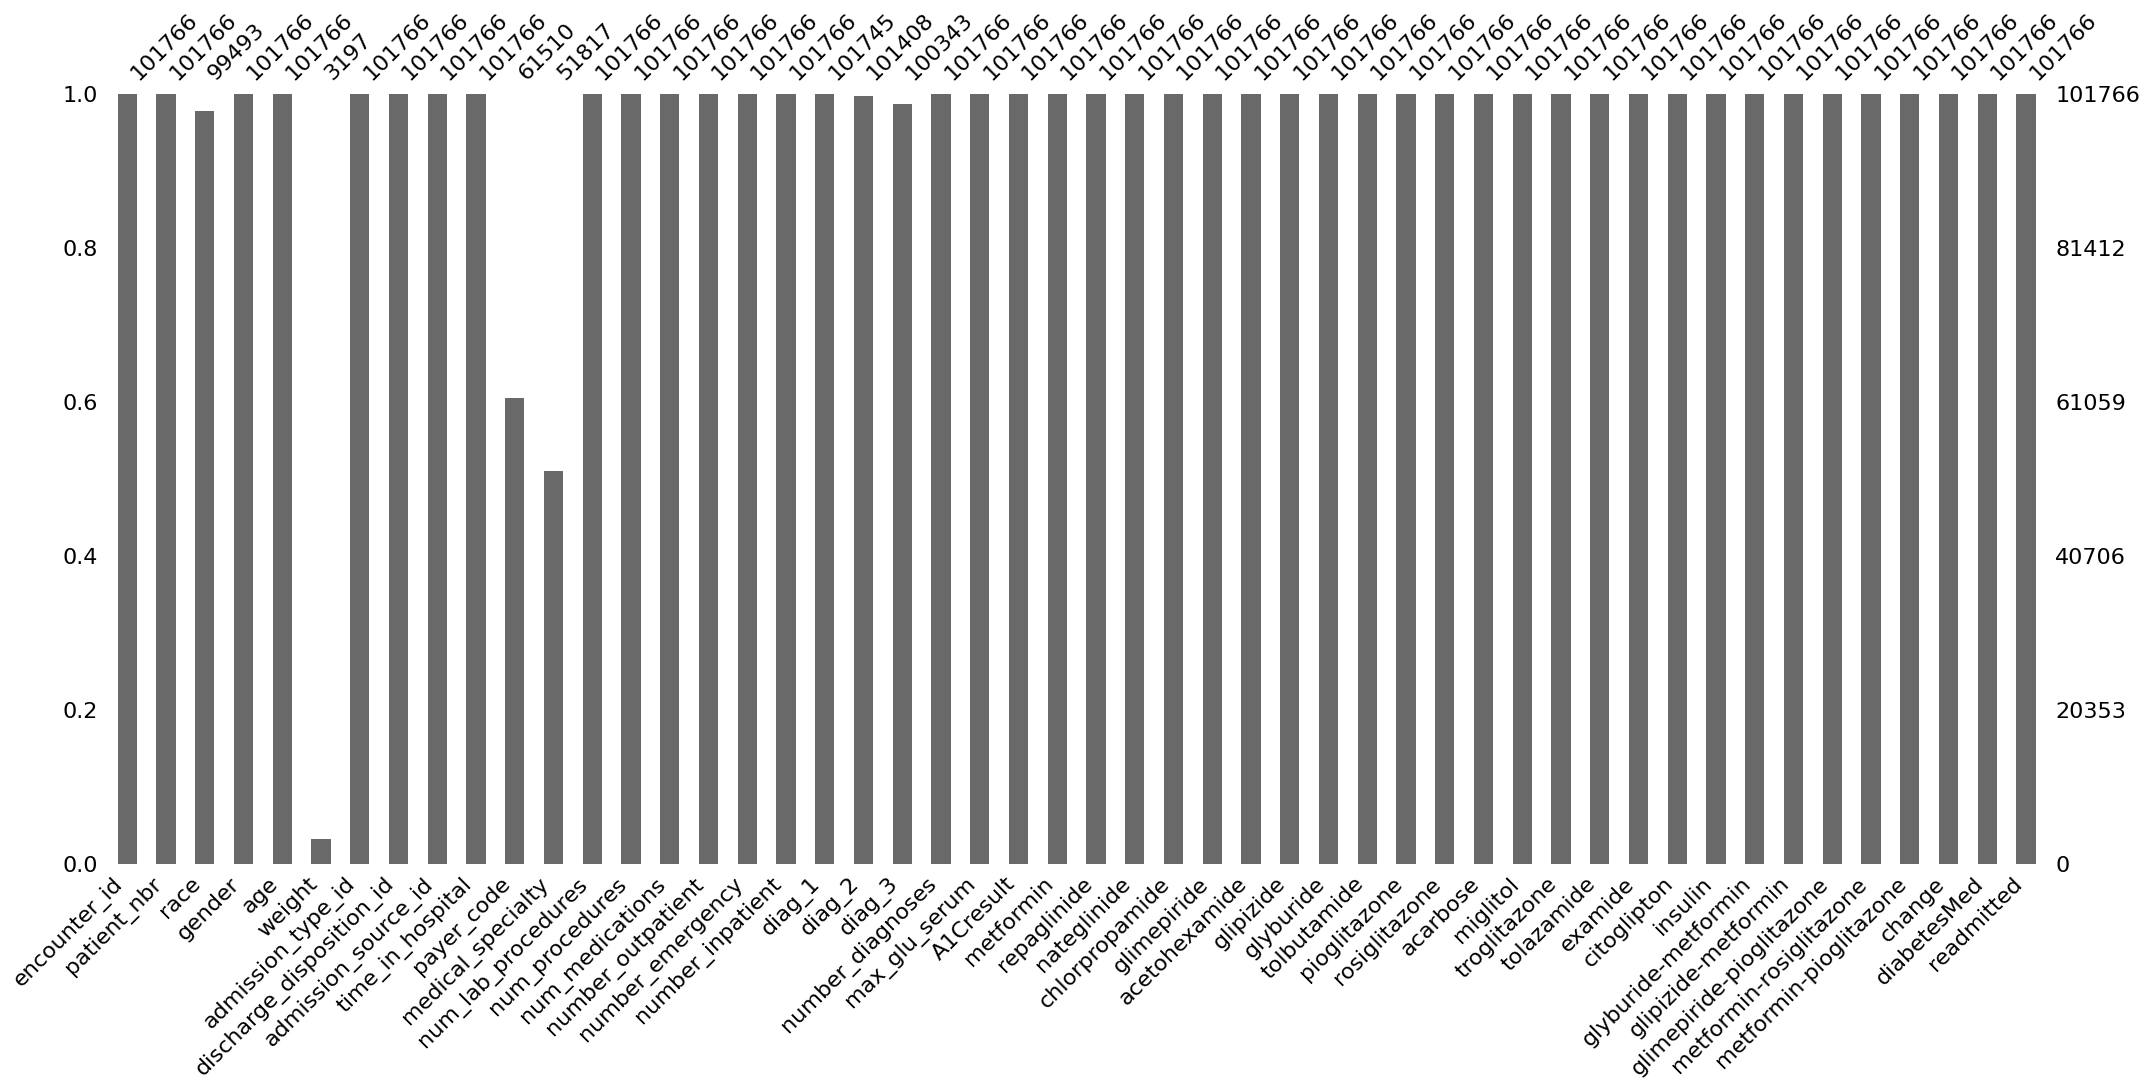

In [84]:
# Check for missing values
data_cleaned = data.replace('?', np.NaN) 
#print(data_cleaned.isnull().sum())

# Visualize missing data in each column
msno.bar(data_cleaned)

# Calculate the percentage of missing values in each column
missing_data_percentage = data_cleaned.isna().mean(axis=0) * 100

# Print the results
for column_name, percentage in zip(missing_data_percentage.index, missing_data_percentage.values):
    print(f"{column_name}: {percentage:.2f}%")

In [85]:
# Weight, payer_code, and medical_speciality has too many missing data
# Delete these three coloums from the dataset
data_cleaned = data_cleaned.drop([ 'weight', 'payer_code', 'medical_specialty'], axis=1)


In [86]:
#remove constant features
data_cleaned = data_cleaned.drop(['examide', 'citoglipton','glimepiride-pioglitazone'], axis=1) 

In [87]:
# Check for duplicates
print(data_cleaned.duplicated().sum())
#print(data_cleaned.isnull().sum())


0


There are no duplications in the data.

The following fields in the "discharge_disposition_id" are for patients who are deceased:

11 Expired																
19 Expired at home. Medicaid only, hospice.			
20 Expired in a medical facility. Medicaid only, hospice.									
21 Expired, place unknown. Medicaid only, hospice.

The next step is to removed these records from the data. 							

In [88]:
# Remove deceased patients 
# Drop the rows where discharge disposition ID is 11, 19, 20, or 21
data_cleaned = data_cleaned[~data_cleaned["discharge_disposition_id"].isin([11, 19, 20,21])]

# Reset the index to reassign sequential index labels to the rows
data_cleaned = data_cleaned.reset_index(drop=True)


In [89]:
# Removing the unnecessary columns
data_cleaned = data_cleaned.drop(['encounter_id', 'patient_nbr'], axis=1)


Define a new target variable to be used in the prediction model that best describes the problem statement: predict the risk of diabetic patients' readmission to hospitals. 

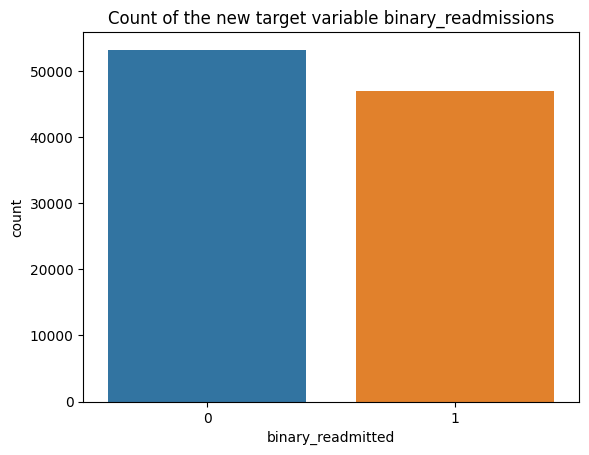

Percentage of patients readmitted to hospital: 46.85%
Percentage of patients not readmitted to hospital: 53.15%


In [90]:
# Define a new coloumn 'binary_readmitted' that contains two values: 1 = readmitted withing 30 days, 0= otherwise 
data_cleaned['binary_readmitted'] = np.where(data_cleaned['readmitted'] == 'NO', 0, 1)

# Visualize the distribution of the target variable
sns.countplot(x='binary_readmitted', data=data_cleaned)
plt.title("Count of the new target variable binary_readmissions")
plt.show()
# Count the patients been readmitted
readmitted_count = data_cleaned[data_cleaned['binary_readmitted'] == 1].shape[0]

# Calculate the percentage of patients been readmitted
readmitted_percent = (readmitted_count / data_cleaned.shape[0]) * 100
not_readmitted_percent = 100-readmitted_percent
print("Percentage of patients readmitted to hospital: {:.2f}%".format(readmitted_percent))
print("Percentage of patients not readmitted to hospital: {:.2f}%".format(not_readmitted_percent))


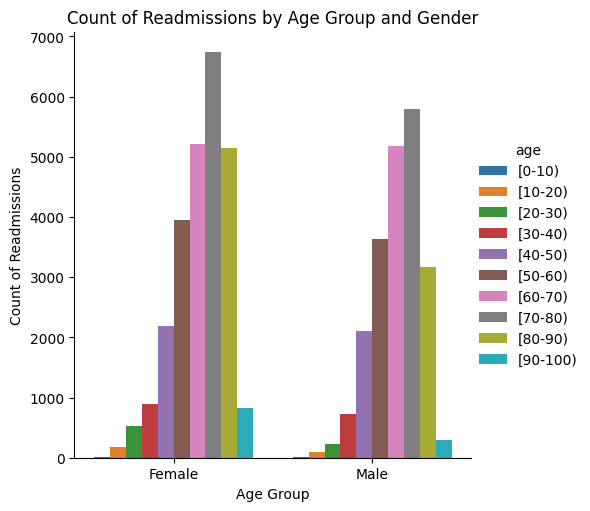

In [91]:

# Filter for male and female patients only
data_cleaned = data_cleaned[data_cleaned["gender"].isin(["Male", "Female"])]

# Count the number of patients who were readmitted for each gender and age group
counts = data_cleaned[data_cleaned["binary_readmitted"] == 1].groupby(["gender", "age"]).size().reset_index(name="count")

# Plot the bar chart using Seaborn
sns.catplot(x="gender", y="count", hue="age", kind="bar", data=counts)

# Set the axis labels and title
plt.xlabel("Age Group")
plt.ylabel("Count of Readmissions")
plt.title("Count of Readmissions by Age Group and Gender")

# Show the plot
plt.show()


In [92]:
print("Count of male and female patients who were readmitted for each age group:\n",counts)

Count of male and female patients who were readmitted for each age group:
     gender       age  count
0   Female    [0-10)     14
1   Female   [10-20)    171
2   Female   [20-30)    523
3   Female   [30-40)    889
4   Female   [40-50)   2196
5   Female   [50-60)   3956
6   Female   [60-70)   5218
7   Female   [70-80)   6743
8   Female   [80-90)   5137
9   Female  [90-100)    823
10    Male    [0-10)     15
11    Male   [10-20)     93
12    Male   [20-30)    223
13    Male   [30-40)    722
14    Male   [40-50)   2109
15    Male   [50-60)   3629
16    Male   [60-70)   5181
17    Male   [70-80)   5801
18    Male   [80-90)   3164
19    Male  [90-100)    295


In [93]:

# Load the diabetic_data.csv file
df = data_cleaned

# Filter for male and female patients only
df = df[df["gender"].isin(["Male", "Female"])]

# Calculate the readmission rates by gender
readmit_rates = df.groupby("gender")["binary_readmitted"].value_counts(normalize=True).mul(100).rename("percentage").reset_index()

# Print the readmission rate
print("Readmission rate:", readmit_rates)

Readmission rate:    gender  binary_readmitted  percentage
0  Female                  0   52.340283
1  Female                  1   47.659717
2    Male                  0   54.092973
3    Male                  1   45.907027


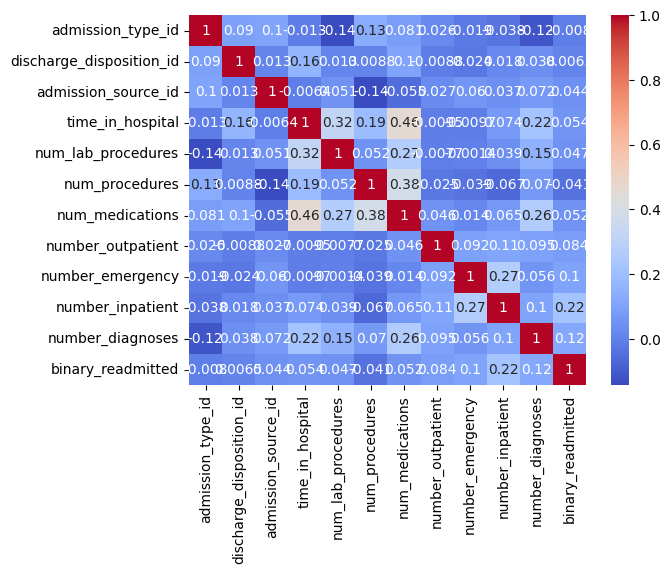

Features with high correlation to target variable:
 ['number_emergency', 'number_inpatient', 'number_diagnoses', 'binary_readmitted']


In [94]:
# Calculate correlations between numerical columns
numerical_columns = data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlations = data_cleaned[numerical_columns].corr()

# Visualize the correlations using a heatmap
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

# Identify features with high correlation to the target variable
target_corr = correlations["binary_readmitted"].abs()
high_corr_features = target_corr[target_corr > 0.1].index.tolist()
print("Features with high correlation to target variable:\n", high_corr_features)

In [95]:
# Prepare the dataset for modeling
# Select the categorical columns to one-hot 
cat_cols = data_cleaned.select_dtypes(include=['object']).columns.tolist()

# Apply one-hot encoding to the categorical columns
data_coded = pd.get_dummies(data_cleaned, columns=cat_cols)

# Define X to contiang the features that will be used for the traing and y as the target variable. 

X = data_coded.drop(["binary_readmitted"], axis=1)
X = X.drop(["readmitted_NO"], axis=1)
X = X.drop(["readmitted_>30"], axis=1)
X = X.drop(["readmitted_<30"], axis=1)

y = data_coded["binary_readmitted"]

# split the data into training and testing sets, with 30% of the data used for testing
# The random_state parameter is set to a fixed value of 0 to ensure reproducibility of the results.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#print train and dataset size
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70077, 2356)
(30034, 2356)
(70077,)
(30034,)



# Data wrangling for model training:




# Scaling

In [96]:

# Scale the data using scaler.fit_transform for the thraing data and scaler.transform for the test data
#scaler.fit_transform learns the mean and sd for each feature from fitting the scaler on the training data
#scalre.transrom applies the scaling on the test data using the learned mean and sd 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#transfrom X_train and X_test into a panda dataframe
X_train= pd.DataFrame(X_train)
X_test= pd.DataFrame(X_test)

# Feature selection

In [97]:

# Apply feature selection on the training data
selector = SelectKBest(f_classif, k=10)
# Fit the selector on the training data
selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[selector.get_support()]
#print("Selected features:", selected_features)
# Print the selected features and their indices
selected_features_names =''
for i, feat_idx in enumerate(selected_features):
   print(f"Feature {i}: {X.columns[feat_idx]} (index position: {feat_idx})")
   selected_features_names +=','+X.columns[feat_idx]

# Transform the training and testing data to include only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Convert the transformed data back to a DataFrame with the selected features
X_train = pd.DataFrame(X_train_selected, columns=selected_features)
X_test= pd.DataFrame(X_test_selected, columns=selected_features)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  28  194  209  215  232  238  257  273  399  400  417  454  458  479
  504  505  515  518  556  586  618  643  656  659  670  681  683  686
  703  704  705  713  725  737  745  747  750  770  775  804  809  811
  866  942  946 1035 1043 1078 1081 1085 1091 1098 1142 1145 1171 1177
 1178 1181 1183 1245 1294 1312 1329 1332 1346 1358 1362 1380 1386 1398
 1399 1423 1440 1478 1485 1492 1497 1504 1520 1527 1537 1558 1566 1661
 1668 1690 1704 1716 1725 1760 1798 1806 1849 1851 1869 1895 1900 1901
 1934 1937 1943 1945 1946 1950 1959 2066 2087 2090 2091 2093 2125 2128
 2135 2149 2150 2161 2166 2167 2168 2190 2193 2194 2195 2200 2201 2235
 2251] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in

Feature 0: time_in_hospital (index position: 3)
Feature 1: number_outpatient (index position: 7)
Feature 2: number_emergency (index position: 8)
Feature 3: number_inpatient (index position: 9)
Feature 4: number_diagnoses (index position: 10)
Feature 5: diag_1_428 (index position: 304)
Feature 6: diag_2_250 (index position: 820)
Feature 7: diag_3_250 (index position: 1576)
Feature 8: diabetesMed_No (index position: 2354)
Feature 9: diabetesMed_Yes (index position: 2355)


In [98]:
X_train.head

<bound method NDFrame.head of            3         7         8         9         10      304       820   \
0     -0.803452 -0.292236 -0.211862  0.285507 -0.724017 -0.2712 -0.254697   
1     -0.803452  0.487590 -0.211862  0.285507 -0.724017 -0.2712 -0.254697   
2     -0.803452 -0.292236 -0.211862 -0.500486  0.822102 -0.2712 -0.254697   
3     -0.467530 -0.292236 -0.211862 -0.500486  0.306729 -0.2712 -0.254697   
4     -0.803452 -0.292236 -0.211862 -0.500486  0.822102 -0.2712 -0.254697   
...         ...       ...       ...       ...       ...     ...       ...   
70072 -1.139374 -0.292236 -0.211862 -0.500486 -0.724017 -0.2712 -0.254697   
70073  1.548001 -0.292236 -0.211862 -0.500486  0.306729 -0.2712 -0.254697   
70074 -1.139374 -0.292236 -0.211862 -0.500486 -2.270137 -0.2712  3.926235   
70075  1.212079 -0.292236 -0.211862  0.285507  0.822102 -0.2712 -0.254697   
70076  2.555766  8.285851 -0.211862 -0.500486  0.822102 -0.2712 -0.254697   

           1576      2354      2355  
0     -

# Machine learning models:


*   Logistic Regression:



In [99]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
y_pred_LR = LR_model.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_pred_LR))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_LR))
print('Classification report:\n', classification_report(y_test, y_pred_LR))

# Print coefficients
#The key parameter of the sorted() function is used to specify the sorting key,
# which is the absolute value of the coefficient in this case. 
#The minus sign in front of abs(x[0]) is used to sort in descending order.
print("Coefficients:")
for coef, feature in sorted(zip(LR_model.coef_[0], X.columns) , key=lambda x: -abs(x[0])):
    print(f"  {feature}: {coef:.3f}")

# Get the feature coefficients
coefficients = LR_model.coef_

# Get the absolute value of the coefficients
abs_coefficients = np.abs(coefficients)

# Sort the features by absolute coefficient value
indices = np.argsort(abs_coefficients)[0][::-1]




Accuracy score: 0.6202969967370313
Confusion matrix:
 [[12766  3162]
 [ 8242  5864]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.80      0.69     15928
           1       0.65      0.42      0.51     14106

    accuracy                           0.62     30034
   macro avg       0.63      0.61      0.60     30034
weighted avg       0.63      0.62      0.60     30034

Coefficients:
  time_in_hospital: 0.497
  admission_source_id: 0.206
  num_lab_procedures: 0.149
  discharge_disposition_id: 0.113
  num_procedures: 0.106
  number_emergency: -0.049
  number_inpatient: 0.049
  number_outpatient: -0.044
  num_medications: -0.041
  admission_type_id: 0.037




*   Decision Tree Model




In [100]:
# Building the decision tree model with hyperparameter tuning
# Prepare the dataset for modeling

param_grid = {'max_depth': [3, 4, 5, 6], 'min_samples_split': [2, 4, 6, 8]}
DTT_model = GridSearchCV(DecisionTreeClassifier(), param_grid)
DTT_model.fit(X_train, y_train)

# Model evaluation
y_pred_DTT = DTT_model.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_pred_DTT))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_DTT))
print('Classification report:\n', classification_report(y_test, y_pred_DTT))


# Get the best estimator
best_estimator = DTT_model.best_estimator_

# Get the feature importances
importances = best_estimator.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)[::-1]


# Print the best features
n = 6
print("Best %d features:" % n)
for i in range(n):
    print("%d. feature %s (%f)" % (i + 1, X.columns[indices[i]], importances[indices[i]]))


Accuracy score: 0.622461210627955
Confusion matrix:
 [[11519  4409]
 [ 6930  7176]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.72      0.67     15928
           1       0.62      0.51      0.56     14106

    accuracy                           0.62     30034
   macro avg       0.62      0.62      0.61     30034
weighted avg       0.62      0.62      0.62     30034

Best 6 features:
1. feature time_in_hospital (0.704902)
2. feature num_lab_procedures (0.111274)
3. feature admission_source_id (0.055971)
4. feature discharge_disposition_id (0.050418)
5. feature num_procedures (0.029741)
6. feature number_inpatient (0.016674)




*   Random Forest Model



In [101]:
# Building the Random Forest model
RF_model = RandomForestClassifier(n_estimators=100, max_depth=3)
RF_model.fit(X_train, y_train)

# Model evaluation
y_pred_RF = RF_model.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_pred_RF))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_RF))
print('Classification report:\n', classification_report(y_test, y_pred_RF,zero_division=1))

# Get the feature importances
importances = RF_model.feature_importances_

# Sort the features by importance
# reverse the order of the indices using the [::-1] slicing notation to get the indices for a descending order sort.
indices = np.argsort(importances)[::-1]

# Print the features
n = 6
print("Best %d features:" % n)
for i in range(n):
    print("%d. feature %s (%f)" % (i + 1, X.columns[indices[i]], importances[indices[i]]))


Accuracy score: 0.6225943930212426
Confusion matrix:
 [[12104  3824]
 [ 7511  6595]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.76      0.68     15928
           1       0.63      0.47      0.54     14106

    accuracy                           0.62     30034
   macro avg       0.63      0.61      0.61     30034
weighted avg       0.62      0.62      0.61     30034

Best 6 features:
1. feature time_in_hospital (0.527720)
2. feature admission_source_id (0.176565)
3. feature num_lab_procedures (0.111640)
4. feature discharge_disposition_id (0.096842)
5. feature num_procedures (0.039364)
6. feature number_emergency (0.019156)


In [105]:
# Import necessary modules
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

# Define the models to cross-validate
models = [
    ('LR', LR_model),
    ('DT', DTT_model),
    ('RF', RF_model)
]

# Perform 5-fold cross-validation for each model
for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name}: Mean AUC = {scores.mean():.3f}, Std Dev = {scores.std():.3f}")

LR: Mean AUC = 0.658, Std Dev = 0.003
DT: Mean AUC = 0.657, Std Dev = 0.003
RF: Mean AUC = 0.658, Std Dev = 0.003


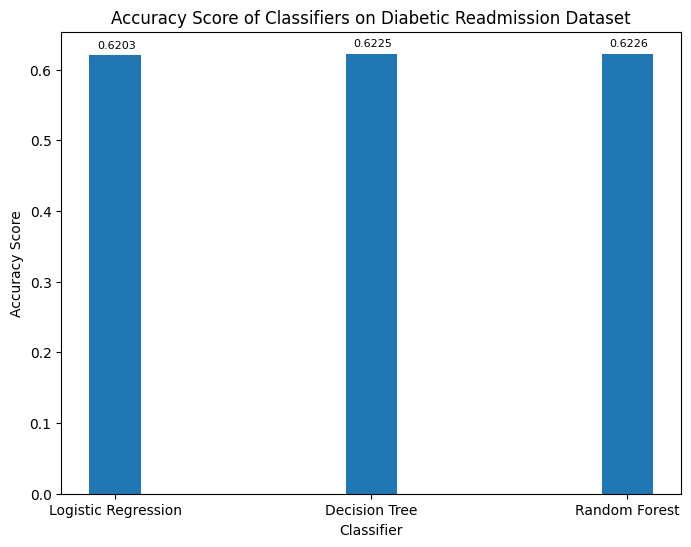

[0.6202969967370313, 0.622461210627955, 0.6225943930212426]


In [102]:
# Calculate the performance metrics of each classifier

# Calculate the accuracy score of each classifier
accuracy_LR = accuracy_score(y_test, y_pred_LR)
accuracy_DTT = accuracy_score(y_test, y_pred_DTT)
accuracy_RF = accuracy_score(y_test, y_pred_RF)
accuracies = [accuracy_LR, accuracy_DTT, accuracy_RF]

# Plot a bar chart of the accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(models, accuracies,width=0.2)
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy Score')
ax.set_title('Accuracy Score of Classifiers on Diabetic Readmission Dataset')
# Add values on top of each bar
for i, v in enumerate(accuracies):
    ax.text(i - 0.07, v + 0.01, str(round(v, 4)), fontsize=8)
plt.show()
print (accuracies)

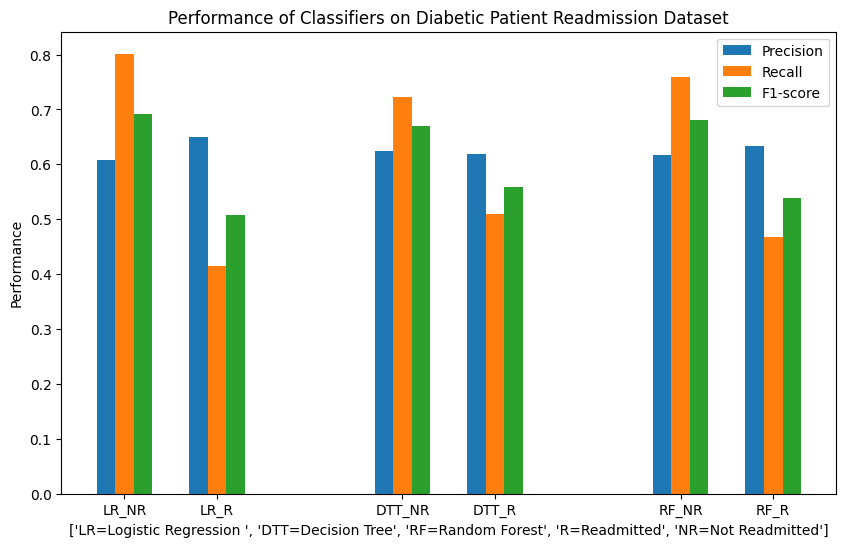

In [103]:


# Calculate the classification report of each classifier
report_LR = classification_report(y_test, y_pred_LR, target_names=['No Readmission', 'Readmission'], output_dict=True)
report_DTT = classification_report(y_test, y_pred_DTT, target_names=['No Readmission', 'Readmission'], output_dict=True)
report_RF = classification_report(y_test, y_pred_RF, target_names=['No Readmission', 'Readmission'], output_dict=True)

# Extract the performance metrics from the classification report
precision = [report_LR['No Readmission']['precision'], report_LR['Readmission']['precision'], 
             report_DTT['No Readmission']['precision'], report_DTT['Readmission']['precision'],
             report_RF['No Readmission']['precision'], report_RF['Readmission']['precision']]
recall = [report_LR['No Readmission']['recall'], report_LR['Readmission']['recall'], 
          report_DTT['No Readmission']['recall'], report_DTT['Readmission']['recall'],
          report_RF['No Readmission']['recall'], report_RF['Readmission']['recall']]
f1 = [report_LR['No Readmission']['f1-score'], report_LR['Readmission']['f1-score'], 
      report_DTT['No Readmission']['f1-score'], report_DTT['Readmission']['f1-score'],
      report_RF['No Readmission']['f1-score'], report_RF['Readmission']['f1-score']]

# Plot a grouped bar chart of the performance metrics
models = ['LR=Logistic Regression ', 'DTT=Decision Tree', 'RF=Random Forest','R=Readmitted', 'NR=Not Readmitted']
metrics = ['Precision', 'Recall', 'F1-score']
index = [0, 1, 3, 4, 6, 7]


fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(index, precision, width=0.2, label='Precision')
ax.bar([i + 0.2 for i in index], recall, width=0.2, label='Recall')
ax.bar([i + 0.4 for i in index], f1, width=0.2, label='F1-score')
ax.set_xlabel(models)
ax.set_ylabel('Performance')
ax.set_title('Performance of Classifiers on Diabetic Patient Readmission Dataset')
ax.set_xticks([0.2, 1.2, 3.2, 4.2, 6.2, 7.2])
# notations : R = Readmitted, NR = Not Readmitted
ax.set_xticklabels([ 'LR_NR','LR_R', 'DTT_NR', 'DTT_R', 'RF_NR', 'RF_R'])
ax.legend()
plt.show()


In [104]:
print(precision)
print(recall)
print(f1)

[0.6076732673267327, 0.6496787059605584, 0.6243698845465879, 0.6194216659473457, 0.6170787662503187, 0.6329782128803149]
[0.8014816675037669, 0.41570962710903164, 0.7231918633852336, 0.5087196937473416, 0.7599196383726771, 0.46753154685949244]
[0.691249729261425, 0.5070032854919593, 0.6701573726619542, 0.5586392121754701, 0.6810905100863743, 0.5378185524974516]
